In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

### ANOVA test

In this notebook, I will summarise the process required to perform an Analysis of Variance test (ANOVA test), including the steps required to make sure that the data fits the requirements for an ANOVA test. The aim of ANOVA is to test whether the mean of a set of populations is similar. In order to do that, a sample is extracted from each population, an we perform a test with the following definition:

- Null hypothesis: the mean of all the populations is the same
- Alternative hypothesis: at least one of the populations has a different mean

The reason why we perform ANOVA instead of multiple two-sample t-tests is because such a process would be prone to induce Type I errors: due to the randomness of the data it is likely of find a difference between two populations even if such difference does not exist. 

Let's start this example by generating four samples corresponding to four different populations represented by four different normal distributions.

In [2]:
np.random.seed(0)

In [3]:
MEAN = [
    1.2, 
    1.1,
    1.5,
    1.13
]

STD = [
    0.6,
    0.68,
    0.65,
    0.66
]

N = [
    61,
    60,
    63,
    65
]

In [4]:
samples = [np.random.normal(loc=MEAN[i], scale=STD[i], size=N[i]) for i in range(4)]

### Can we apply an ANOVA test?

In this first section we check the conditions for applying an ANOVA test on the data. 

**Independence**

Let's assume that the sample data corresponds to less than 10% of the total population and that each sample was observed independently of the other ones.

**Normally distributed data**

Let's test normality for each sample by means of Q-Q plots

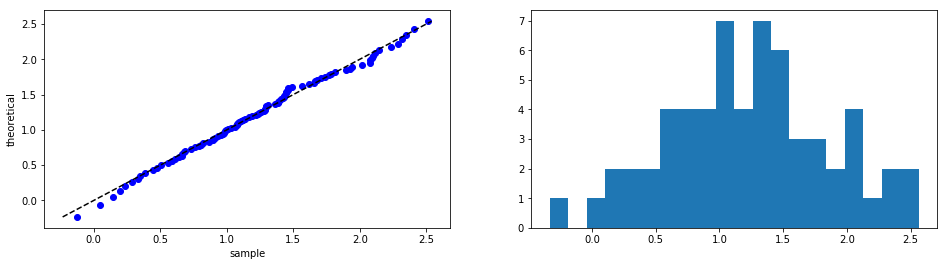

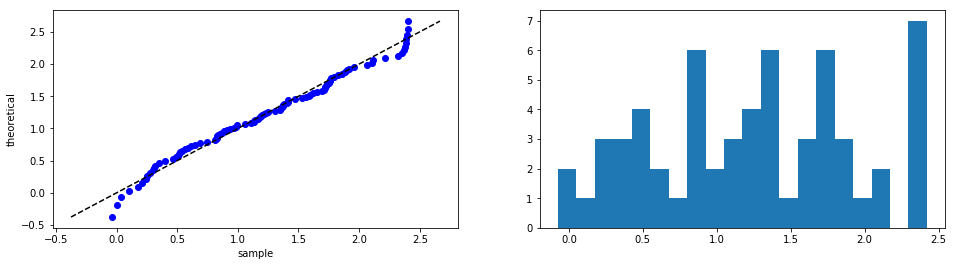

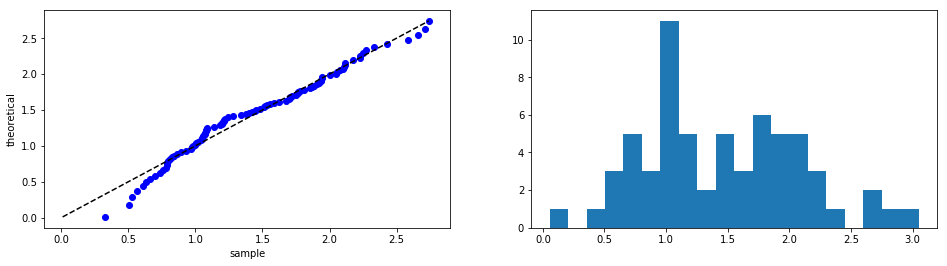

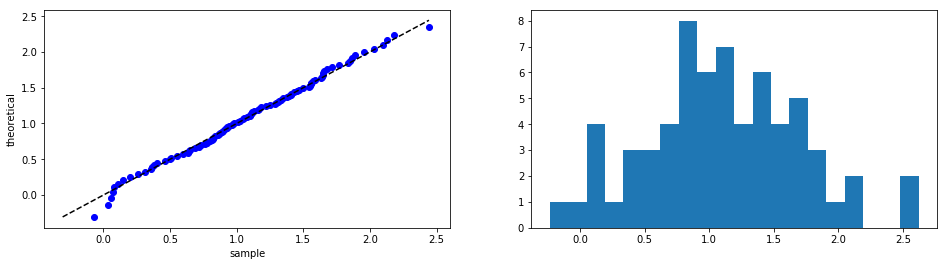

In [5]:
def plot_q_q(sample):
    # Theoretical quantiles
    quantiles = np.arange(0.01,0.99,0.01)
    q_theoretical = [scipy.stats.norm.ppf(i, loc=np.mean(sample), scale=np.std(sample)) for i in quantiles]
    # Sample quantiles
    q_sample = [np.percentile(sample, i*100) for i in quantiles]
    # Plotting the quantiles
    fig, ax = plt.subplots(1,2)
    ax[0].scatter(q_sample, q_theoretical, color='blue')
    # Plotting the diagonal line
    min_value = min(np.min(q_theoretical), np.min(q_sample))
    max_value = max(np.max(q_theoretical), np.max(q_sample))
    ax[0].plot([min_value, max_value], [min_value, max_value], 'k--')

    ax[0].set_xlabel('sample')
    ax[0].set_ylabel('theoretical')
    
    # histogram
    ax[1].hist(sample, bins=20)
    
    fig.set_figwidth(16)
    
for s in samples:
    plot_q_q(s)

The second and the third samples seem to be skewed, but there are no clear outliers and the samples seem to be large enough to proceed with the analysis. 

**Similar variances**

Let's use side-by-side box plots to determine whether the variance of the groups is similar to the point of being almost the same. 

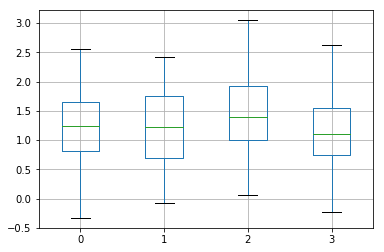

In [6]:
df = pd.DataFrame(samples).transpose()
df.boxplot()

There seems to be some differences, but we can accept this difference is the number of observations accross samples is consistent. All the samples contain a very similar number of observations. 

### ANOVA test

Manually computing the F-statistic and the p-value in the ANOVA test is tedious and prone to error, and therefore we use the built-in ANOVA functionalities in Python libraries rather than implmenting this code from scratch. 

In [7]:
scipy.stats.f_oneway(samples[0], samples[1], samples[2], samples[3])

F_onewayResult(statistic=3.3290334578799654, pvalue=0.02026341442461204)

The first value corresponds to the F-statistic, calculated as the ration between the difference between group means and data variability. The second value is the p-value. 


Since the p-value is lower than the significance level of 0.05 we reject the null hypothesis. Not all the means are the same. 

### Multiple comparisons

Once we reject the null hypothesis in the ANOVA test we can perform a two-sample t-test for each pair of groups with a modified significance level and a pooled standard deviation. The pool standard deviation, as well as the value of df, is usually obtained by means of software, whereas the modified significance level is calculated by means of the Bonferroni correction.

Unfortunately, I didn't find any package in Python that returns the degrees of freedom for multiple comparisons after an ANOVA test. Therefore, I am using instead the parirwise Turkey-Kramer HSD test.

In [8]:
df = pd.DataFrame(np.array([samples[0], [0]*len(samples[0])]).T, columns=['value','group'])
for i in range(1,4):
    s = samples[i]
    df = pd.concat([df, pd.DataFrame(np.array([s, [i]*len(s)]).T, columns=['value','group'])])

In [9]:
print(pairwise_tukeyhsd(df['value'], df['group']))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    1.0    0.0015  -0.3015  0.3044 False 
 0.0    2.0    0.2191  -0.0802  0.5184 False 
 0.0    3.0   -0.1369  -0.4339  0.1601 False 
 1.0    2.0    0.2176  -0.0829  0.5182 False 
 1.0    3.0   -0.1384  -0.4366  0.1599 False 
 2.0    3.0    -0.356  -0.6505 -0.0614  True 
---------------------------------------------


From this result we can conclude that there is a difference between the third (mean = 5) and fourth (mean = 1.13) groups. Unfortunately, this method is not returning the p-value. 

If this test hadn't returned any difference between groups, we would have still rejected the null hypothesis in the ANOVA test. However, the conclusion would have been that we do not have enough evidence to determine which groups are different. 